# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   land_speed              1206 non-null   float64
 1   level                   1206 non-null   int64  
 2   fortitude               1206 non-null   int64  
 3   focus                   1206 non-null   int32  
 4   wis                     1206 non-null   int64  
 5   num_immunities          1206 non-null   int64  
 6   book                    1206 non-null   object 
 7   cha                     1206 non-null   int64  
 8   con                     1206 non-null   int64  
 9   ac                      1206 non-null   int64  
 10  str                     1206 non-null   int64  
 11  int                     1206 non-null   int64  
 12  will                    1206 non-null   int64  
 13  dex                     1206 non-null   int64  
 14  hp                      1206 non-null   

In [3]:
df.head()

,land_speed,level,fortitude,focus,wis,num_immunities,book,cha,con,ac,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,30.0,10,22,1,2,3,Pathfinder Bestiary,1,5,29,...,0,0,0,0,0,0,23,22.0,0,0.0
1,35.0,10,21,0,2,0,Pathfinder Bestiary,1,5,28,...,0,0,0,0,0,0,23,22.0,0,0.0
2,30.0,8,20,0,3,0,Pathfinder Bestiary,-2,6,25,...,0,0,0,0,0,0,21,16.0,0,0.0
3,50.0,17,30,1,5,3,Pathfinder Bestiary,6,5,41,...,1,0,1,0,0,0,33,31.5,0,0.0
4,0.0,1,6,1,1,0,Pathfinder Bestiary,1,1,16,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


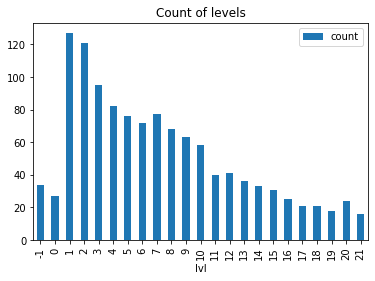

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.460853	valid_0's l2: 0.927292


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = median_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.93
RMSE: 0.96
MAE: 0.24


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.12
RMSE test: 0.96


In [17]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.93
RMSE: 0.96

Round type: round
MSE: 0.96
RMSE: 0.98

Round type: 0.33
MSE: 0.91
RMSE: 0.95

Round type: 0.45
MSE: 0.93
RMSE: 0.96



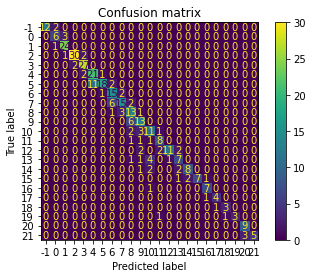

In [18]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [19]:
from training.results import assess_regression_model

In [20]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 18:11:09,397] A new study created in memory with name: no-name-a16d0325-6823-4134-8118-fede4466ef03
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.146998 + 0.0341857
[200]	cv_agg's l2: 0.144533 + 0.033041
[300]	cv_agg's l2: 0.143689 + 0.0326158
[400]	cv_agg's l2: 0.143172 + 0.0323378
[500]	cv_agg's l2: 0.143083 + 0.0320616
[600]	cv_agg's l2: 0.142901 + 0.0317219


feature_fraction, val_score: 0.142854:  14%|######4                                      | 1/7 [00:03<00:20,  3.45s/it]

[700]	cv_agg's l2: 0.142901 + 0.0317555
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.142854 + 0.0316972
[100]	cv_agg's l2: 0.150661 + 0.0364115
[200]	cv_agg's l2: 0.148517 + 0.0352203
[300]	cv_agg's l2: 0.147946 + 0.0355016
[400]	cv_agg's l2: 0.14781 + 0.0357645
[500]	cv_agg's l2: 0.147823 + 0.0358567
[600]	cv_agg's l2: 0.14782 + 0.0358522


feature_fraction, val_score: 0.142854:  29%|############8                                | 2/7 [00:07<00:17,  3.58s/it]

[700]	cv_agg's l2: 0.14792 + 0.0357587
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.142854 + 0.0316972
[100]	cv_agg's l2: 0.149514 + 0.0332166
[200]	cv_agg's l2: 0.143468 + 0.0332606
[300]	cv_agg's l2: 0.141923 + 0.0322977
[400]	cv_agg's l2: 0.141622 + 0.0321829


feature_fraction, val_score: 0.141420:  43%|###################2                         | 3/7 [00:10<00:13,  3.39s/it]

[500]	cv_agg's l2: 0.141495 + 0.032486
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.14142 + 0.0321319
[100]	cv_agg's l2: 0.150882 + 0.0332203
[200]	cv_agg's l2: 0.147288 + 0.0317476
[300]	cv_agg's l2: 0.146838 + 0.0316794
[400]	cv_agg's l2: 0.146386 + 0.0310858


feature_fraction, val_score: 0.141420:  57%|#########################7                   | 4/7 [00:13<00:10,  3.35s/it]

[500]	cv_agg's l2: 0.146308 + 0.0311808
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.14142 + 0.0321319
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984


feature_fraction, val_score: 0.132170:  71%|################################1            | 5/7 [00:18<00:07,  3.75s/it]

Early stopping, best iteration is:
[570]	cv_agg's l2: 0.13217 + 0.029615
[100]	cv_agg's l2: 0.143796 + 0.0361147
[200]	cv_agg's l2: 0.139603 + 0.0341927
[300]	cv_agg's l2: 0.13943 + 0.033934
[400]	cv_agg's l2: 0.13937 + 0.0338862
[500]	cv_agg's l2: 0.139491 + 0.0338769
[600]	cv_agg's l2: 0.139436 + 0.0337748


feature_fraction, val_score: 0.132170:  86%|######################################5      | 6/7 [00:23<00:04,  4.32s/it]

Early stopping, best iteration is:
[570]	cv_agg's l2: 0.13217 + 0.029615
[100]	cv_agg's l2: 0.144422 + 0.0355106
[200]	cv_agg's l2: 0.140095 + 0.0327268
[300]	cv_agg's l2: 0.138838 + 0.0317895
[400]	cv_agg's l2: 0.138322 + 0.0313742
[500]	cv_agg's l2: 0.138139 + 0.0311488
[600]	cv_agg's l2: 0.138062 + 0.0310151


feature_fraction, val_score: 0.132170: 100%|#############################################| 7/7 [00:33<00:00,  4.75s/it]


Early stopping, best iteration is:
[570]	cv_agg's l2: 0.13217 + 0.029615


num_leaves, val_score: 0.132170:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984


num_leaves, val_score: 0.132170:   5%|##5                                               | 1/20 [00:10<03:10, 10.04s/it]

Early stopping, best iteration is:
[570]	cv_agg's l2: 0.13217 + 0.029615
[100]	cv_agg's l2: 0.141967 + 0.0306313
[200]	cv_agg's l2: 0.134688 + 0.030022
[300]	cv_agg's l2: 0.131565 + 0.0283739
[400]	cv_agg's l2: 0.130463 + 0.0277319
[500]	cv_agg's l2: 0.12987 + 0.0271318
[600]	cv_agg's l2: 0.129673 + 0.0269092


num_leaves, val_score: 0.129390:  10%|#####                                             | 2/20 [00:15<02:10,  7.27s/it]

[700]	cv_agg's l2: 0.129743 + 0.0269066
Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.147036 + 0.0333207
[200]	cv_agg's l2: 0.140281 + 0.0306176
[300]	cv_agg's l2: 0.137577 + 0.0294058
[400]	cv_agg's l2: 0.136805 + 0.0297277
[500]	cv_agg's l2: 0.136287 + 0.0294839
[600]	cv_agg's l2: 0.13618 + 0.0294505


num_leaves, val_score: 0.129390:  15%|#######5                                          | 3/20 [00:20<01:44,  6.16s/it]

[700]	cv_agg's l2: 0.136127 + 0.0294112
Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  20%|##########                                        | 4/20 [00:29<01:56,  7.27s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  25%|############5                                     | 5/20 [00:38<02:02,  8.14s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  30%|###############                                   | 6/20 [00:48<02:00,  8.57s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.196464 + 0.0352761
[200]	cv_agg's l2: 0.176984 + 0.0343154
[300]	cv_agg's l2: 0.168447 + 0.0332883
[400]	cv_agg's l2: 0.162969 + 0.0317499
[500]	cv_agg's l2: 0.15905 + 0.0316013
[600]	cv_agg's l2: 0.155783 + 0.0317278


num_leaves, val_score: 0.129390:  35%|#################5                                | 7/20 [00:50<01:24,  6.53s/it]

[700]	cv_agg's l2: 0.153493 + 0.0313067
Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  40%|####################                              | 8/20 [01:00<01:31,  7.62s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  45%|######################5                           | 9/20 [01:10<01:31,  8.31s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  50%|########################5                        | 10/20 [01:20<01:27,  8.79s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  55%|##########################9                      | 11/20 [01:29<01:21,  9.04s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  60%|#############################4                   | 12/20 [01:39<01:13,  9.18s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  65%|###############################8                 | 13/20 [01:48<01:04,  9.28s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  70%|##################################3              | 14/20 [01:58<00:55,  9.28s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  75%|####################################7            | 15/20 [02:07<00:46,  9.27s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.139469 + 0.0315395
[200]	cv_agg's l2: 0.134603 + 0.0311892
[300]	cv_agg's l2: 0.133674 + 0.0305558
[400]	cv_agg's l2: 0.133227 + 0.0304685
[500]	cv_agg's l2: 0.133066 + 0.0303532
[600]	cv_agg's l2: 0.133051 + 0.0303875
[700]	cv_agg's l2: 0.133026 + 0.0302808


num_leaves, val_score: 0.129390:  80%|#######################################2         | 16/20 [02:16<00:37,  9.30s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  85%|#########################################6       | 17/20 [02:27<00:28,  9.66s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  90%|############################################1    | 18/20 [02:36<00:19,  9.55s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390:  95%|##############################################5  | 19/20 [02:46<00:09,  9.65s/it]

Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.140171 + 0.0324951
[200]	cv_agg's l2: 0.134115 + 0.0306861
[300]	cv_agg's l2: 0.133274 + 0.0300347
[400]	cv_agg's l2: 0.132603 + 0.0296978
[500]	cv_agg's l2: 0.132291 + 0.0296754
[600]	cv_agg's l2: 0.132233 + 0.0295984
[700]	cv_agg's l2: 0.132313 + 0.0296672


num_leaves, val_score: 0.129390: 100%|#################################################| 20/20 [02:55<00:00,  8.79s/it]


Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888


bagging, val_score: 0.129390:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.156646 + 0.0217755
[200]	cv_agg's l2: 0.149476 + 0.020186
[300]	cv_agg's l2: 0.147898 + 0.0189253
[400]	cv_agg's l2: 0.146412 + 0.0201272
[500]	cv_agg's l2: 0.146671 + 0.0214761
[600]	cv_agg's l2: 0.147313 + 0.0214966


bagging, val_score: 0.129390:  10%|#####3                                               | 1/10 [00:05<00:47,  5.25s/it]

[700]	cv_agg's l2: 0.147625 + 0.0219247
Early stopping, best iteration is:
[619]	cv_agg's l2: 0.12939 + 0.0267888
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.024847
[400]	cv_agg's l2: 0.129737 + 0.0243564
[500]	cv_agg's l2: 0.129062 + 0.0241057
[600]	cv_agg's l2: 0.128742 + 0.0241581
[700]	cv_agg's l2: 0.128904 + 0.0239739


bagging, val_score: 0.128508:  20%|##########6                                          | 2/10 [00:10<00:42,  5.31s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.144918 + 0.0331308
[200]	cv_agg's l2: 0.13621 + 0.0305959
[300]	cv_agg's l2: 0.133684 + 0.03002
[400]	cv_agg's l2: 0.132892 + 0.0300773
[500]	cv_agg's l2: 0.132433 + 0.0299125
[600]	cv_agg's l2: 0.131963 + 0.0299151
[700]	cv_agg's l2: 0.131969 + 0.0297413


bagging, val_score: 0.128508:  30%|###############9                                     | 3/10 [00:15<00:37,  5.31s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.144684 + 0.0325699
[200]	cv_agg's l2: 0.137798 + 0.0309677
[300]	cv_agg's l2: 0.135507 + 0.0298755
[400]	cv_agg's l2: 0.134046 + 0.0291813
[500]	cv_agg's l2: 0.133337 + 0.0288666
[600]	cv_agg's l2: 0.132758 + 0.0284973
[700]	cv_agg's l2: 0.132638 + 0.0284762


bagging, val_score: 0.128508:  40%|#####################2                               | 4/10 [00:20<00:31,  5.21s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.144382 + 0.0284804
[200]	cv_agg's l2: 0.137757 + 0.0262258
[300]	cv_agg's l2: 0.135193 + 0.0245526
[400]	cv_agg's l2: 0.134357 + 0.0244928
[500]	cv_agg's l2: 0.13377 + 0.0235734
[600]	cv_agg's l2: 0.133729 + 0.0233291
[700]	cv_agg's l2: 0.133757 + 0.0234414


bagging, val_score: 0.128508:  50%|##########################5                          | 5/10 [00:26<00:26,  5.25s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.153844 + 0.0352644
[200]	cv_agg's l2: 0.145453 + 0.0368882
[300]	cv_agg's l2: 0.14318 + 0.0365243
[400]	cv_agg's l2: 0.142143 + 0.0364387
[500]	cv_agg's l2: 0.142233 + 0.0363914
[600]	cv_agg's l2: 0.141252 + 0.0357618
[700]	cv_agg's l2: 0.141428 + 0.0357329


bagging, val_score: 0.128508:  60%|###############################8                     | 6/10 [00:31<00:20,  5.23s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.191347 + 0.0322904
[200]	cv_agg's l2: 0.181785 + 0.032845
[300]	cv_agg's l2: 0.178718 + 0.030002
[400]	cv_agg's l2: 0.179253 + 0.0301459
[500]	cv_agg's l2: 0.177582 + 0.0314749
[600]	cv_agg's l2: 0.177949 + 0.0324178
[700]	cv_agg's l2: 0.178278 + 0.032615


bagging, val_score: 0.128508:  70%|#####################################                | 7/10 [00:36<00:15,  5.16s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.158484 + 0.0372348
[200]	cv_agg's l2: 0.149022 + 0.0365799
[300]	cv_agg's l2: 0.147877 + 0.0353303
[400]	cv_agg's l2: 0.147252 + 0.0359969
[500]	cv_agg's l2: 0.146654 + 0.0352726
[600]	cv_agg's l2: 0.146343 + 0.0347569
[700]	cv_agg's l2: 0.146175 + 0.034796


bagging, val_score: 0.128508:  80%|##########################################4          | 8/10 [00:41<00:10,  5.20s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.1615 + 0.0348324
[200]	cv_agg's l2: 0.152439 + 0.0346202
[300]	cv_agg's l2: 0.150989 + 0.0346828
[400]	cv_agg's l2: 0.150227 + 0.0347515
[500]	cv_agg's l2: 0.150436 + 0.0349816
[600]	cv_agg's l2: 0.150054 + 0.0348731
[700]	cv_agg's l2: 0.149978 + 0.0347973


bagging, val_score: 0.128508:  90%|###############################################7     | 9/10 [00:47<00:05,  5.22s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141967 + 0.0306313
[200]	cv_agg's l2: 0.134688 + 0.030022
[300]	cv_agg's l2: 0.131565 + 0.0283739
[400]	cv_agg's l2: 0.130463 + 0.0277319
[500]	cv_agg's l2: 0.12987 + 0.0271318
[600]	cv_agg's l2: 0.129673 + 0.0269092
[700]	cv_agg's l2: 0.129743 + 0.0269066


bagging, val_score: 0.128508: 100%|####################################################| 10/10 [00:52<00:00,  5.22s/it]


Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702


feature_fraction_stage2, val_score: 0.128508:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.144253 + 0.0288213
[200]	cv_agg's l2: 0.135449 + 0.0267034
[300]	cv_agg's l2: 0.132857 + 0.0260386
[400]	cv_agg's l2: 0.131508 + 0.0255752
[500]	cv_agg's l2: 0.131177 + 0.0257343
[600]	cv_agg's l2: 0.131188 + 0.0258991
[700]	cv_agg's l2: 0.13102 + 0.0257362


feature_fraction_stage2, val_score: 0.128508:  17%|######3                               | 1/6 [00:05<00:26,  5.35s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.146324 + 0.0287366
[200]	cv_agg's l2: 0.136562 + 0.0266763
[300]	cv_agg's l2: 0.134487 + 0.0270055
[400]	cv_agg's l2: 0.133808 + 0.0271715
[500]	cv_agg's l2: 0.133715 + 0.0273435
[600]	cv_agg's l2: 0.133539 + 0.0273113
[700]	cv_agg's l2: 0.133485 + 0.0274519


feature_fraction_stage2, val_score: 0.128508:  33%|############6                         | 2/6 [00:10<00:20,  5.22s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.149253 + 0.0272179
[200]	cv_agg's l2: 0.138198 + 0.0269848
[300]	cv_agg's l2: 0.13522 + 0.0263542
[400]	cv_agg's l2: 0.13422 + 0.0266797
[500]	cv_agg's l2: 0.134191 + 0.0263092
[600]	cv_agg's l2: 0.134051 + 0.0265018
[700]	cv_agg's l2: 0.134148 + 0.0265855


feature_fraction_stage2, val_score: 0.128508:  50%|###################                   | 3/6 [00:15<00:15,  5.33s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.148975 + 0.0287233
[200]	cv_agg's l2: 0.139478 + 0.0277732
[300]	cv_agg's l2: 0.135106 + 0.0267206
[400]	cv_agg's l2: 0.134449 + 0.0273712
[500]	cv_agg's l2: 0.134317 + 0.0267674
[600]	cv_agg's l2: 0.133928 + 0.0268268
[700]	cv_agg's l2: 0.133681 + 0.0267845


feature_fraction_stage2, val_score: 0.128508:  67%|#########################3            | 4/6 [00:21<00:10,  5.29s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.160596 + 0.0350717
[200]	cv_agg's l2: 0.149887 + 0.0346322
[300]	cv_agg's l2: 0.146504 + 0.033365
[400]	cv_agg's l2: 0.145236 + 0.0329074
[500]	cv_agg's l2: 0.144775 + 0.0323002
[600]	cv_agg's l2: 0.14461 + 0.0322451
[700]	cv_agg's l2: 0.144823 + 0.0324211


feature_fraction_stage2, val_score: 0.128508:  83%|###############################6      | 5/6 [00:26<00:05,  5.31s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.147096 + 0.0353106
[200]	cv_agg's l2: 0.139243 + 0.0334903
[300]	cv_agg's l2: 0.136911 + 0.0322193
[400]	cv_agg's l2: 0.135875 + 0.0323565
[500]	cv_agg's l2: 0.135262 + 0.0322629
[600]	cv_agg's l2: 0.135165 + 0.032145
[700]	cv_agg's l2: 0.135102 + 0.0318676


feature_fraction_stage2, val_score: 0.128508: 100%|######################################| 6/6 [00:31<00:00,  5.29s/it]


Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702


regularization_factors, val_score: 0.128508:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246378


regularization_factors, val_score: 0.128508:   5%|#9                                    | 1/20 [00:05<01:41,  5.36s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246377


regularization_factors, val_score: 0.128508:  10%|###8                                  | 2/20 [00:10<01:38,  5.45s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.024847
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246377


regularization_factors, val_score: 0.128508:  15%|#####7                                | 3/20 [00:16<01:32,  5.47s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.024847
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246377


regularization_factors, val_score: 0.128508:  20%|#######6                              | 4/20 [00:21<01:26,  5.42s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.024847
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246377


regularization_factors, val_score: 0.128508:  25%|#########5                            | 5/20 [00:27<01:24,  5.63s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246377


regularization_factors, val_score: 0.128508:  30%|###########4                          | 6/20 [00:33<01:18,  5.58s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246378


regularization_factors, val_score: 0.128508:  35%|#############3                        | 7/20 [00:38<01:11,  5.52s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836
[700]	cv_agg's l2: 0.129356 + 0.0246378


regularization_factors, val_score: 0.128508:  40%|###############2                      | 8/20 [00:43<01:05,  5.47s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836


regularization_factors, val_score: 0.128508:  40%|###############2                      | 8/20 [00:49<01:05,  5.47s/it]

[700]	cv_agg's l2: 0.129356 + 0.0246378
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702


regularization_factors, val_score: 0.128508:  45%|#################1                    | 9/20 [00:49<00:59,  5.45s/it]

[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.0248471
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235
[600]	cv_agg's l2: 0.129162 + 0.0247836


regularization_factors, val_score: 0.128508:  50%|##################5                  | 10/20 [00:52<00:48,  4.88s/it]

[700]	cv_agg's l2: 0.129356 + 0.0246378
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.142185 + 0.0281872
[200]	cv_agg's l2: 0.133478 + 0.0271607
[300]	cv_agg's l2: 0.130945 + 0.0254528
[400]	cv_agg's l2: 0.131157 + 0.0257141
[500]	cv_agg's l2: 0.130596 + 0.0252659
[600]	cv_agg's l2: 0.130371 + 0.0255918


regularization_factors, val_score: 0.128508:  55%|####################3                | 11/20 [00:56<00:38,  4.32s/it]

[700]	cv_agg's l2: 0.130291 + 0.0253162
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.146182 + 0.0305979
[200]	cv_agg's l2: 0.138396 + 0.0287898
[300]	cv_agg's l2: 0.135848 + 0.0272851
[400]	cv_agg's l2: 0.134967 + 0.0270359
[500]	cv_agg's l2: 0.135004 + 0.0270228
[600]	cv_agg's l2: 0.134686 + 0.0268981


regularization_factors, val_score: 0.128508:  60%|######################2              | 12/20 [00:59<00:31,  3.97s/it]

[700]	cv_agg's l2: 0.135016 + 0.0271997
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.128508 + 0.0241702
[100]	cv_agg's l2: 0.140259 + 0.0269
[200]	cv_agg's l2: 0.131165 + 0.0260361
[300]	cv_agg's l2: 0.129148 + 0.0253324
[400]	cv_agg's l2: 0.128547 + 0.0252669
[500]	cv_agg's l2: 0.128431 + 0.0252986


regularization_factors, val_score: 0.128093:  65%|########################             | 13/20 [01:02<00:25,  3.66s/it]

[600]	cv_agg's l2: 0.128524 + 0.0254221
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.142233 + 0.0295983
[200]	cv_agg's l2: 0.133102 + 0.0285515
[300]	cv_agg's l2: 0.129524 + 0.0260552
[400]	cv_agg's l2: 0.129503 + 0.0265636
[500]	cv_agg's l2: 0.128966 + 0.0264621


regularization_factors, val_score: 0.128093:  70%|#########################9           | 14/20 [01:05<00:20,  3.44s/it]

[600]	cv_agg's l2: 0.129636 + 0.026827
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.142708 + 0.0267441
[200]	cv_agg's l2: 0.135506 + 0.026691
[300]	cv_agg's l2: 0.133491 + 0.0255146
[400]	cv_agg's l2: 0.133125 + 0.0249094
[500]	cv_agg's l2: 0.133046 + 0.0247384


regularization_factors, val_score: 0.128093:  75%|###########################7         | 15/20 [01:07<00:16,  3.21s/it]

[600]	cv_agg's l2: 0.132868 + 0.0246687
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.142186 + 0.0281876
[200]	cv_agg's l2: 0.133828 + 0.0271152
[300]	cv_agg's l2: 0.131516 + 0.0255289
[400]	cv_agg's l2: 0.13116 + 0.0254533
[500]	cv_agg's l2: 0.130573 + 0.0251743


regularization_factors, val_score: 0.128093:  80%|#############################6       | 16/20 [01:10<00:12,  3.05s/it]

[600]	cv_agg's l2: 0.130127 + 0.0256129
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.024847
[400]	cv_agg's l2: 0.129737 + 0.0243564
[500]	cv_agg's l2: 0.129062 + 0.0241057


regularization_factors, val_score: 0.128093:  85%|###############################4     | 17/20 [01:13<00:08,  2.96s/it]

[600]	cv_agg's l2: 0.128742 + 0.0241581
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.142185 + 0.0281872
[200]	cv_agg's l2: 0.133478 + 0.0271608
[300]	cv_agg's l2: 0.130945 + 0.0254528
[400]	cv_agg's l2: 0.131157 + 0.0257141
[500]	cv_agg's l2: 0.130596 + 0.0252659


regularization_factors, val_score: 0.128093:  90%|#################################3   | 18/20 [01:15<00:05,  2.87s/it]

[600]	cv_agg's l2: 0.130371 + 0.0255918
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.141879 + 0.0280236
[200]	cv_agg's l2: 0.13333 + 0.0257522
[300]	cv_agg's l2: 0.130952 + 0.024847
[400]	cv_agg's l2: 0.130054 + 0.0248328
[500]	cv_agg's l2: 0.129277 + 0.0244235


regularization_factors, val_score: 0.128093:  95%|###################################1 | 19/20 [01:18<00:02,  2.83s/it]

[600]	cv_agg's l2: 0.129162 + 0.0247836
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.142122 + 0.0282292
[200]	cv_agg's l2: 0.134357 + 0.02658
[300]	cv_agg's l2: 0.131343 + 0.0251739
[400]	cv_agg's l2: 0.131052 + 0.0257585
[500]	cv_agg's l2: 0.130527 + 0.0252543


regularization_factors, val_score: 0.128093: 100%|#####################################| 20/20 [01:21<00:00,  4.06s/it]


[600]	cv_agg's l2: 0.130259 + 0.0260039
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857


min_data_in_leaf, val_score: 0.128093:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.158326 + 0.0394285
[200]	cv_agg's l2: 0.150027 + 0.0385185
[300]	cv_agg's l2: 0.147044 + 0.0371225
[400]	cv_agg's l2: 0.146466 + 0.0370018
[500]	cv_agg's l2: 0.146107 + 0.0365326


min_data_in_leaf, val_score: 0.128093:  20%|#########                                    | 1/5 [00:02<00:10,  2.66s/it]

[600]	cv_agg's l2: 0.145968 + 0.0364435
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.727337 + 0.112024
[200]	cv_agg's l2: 0.692757 + 0.12139
[300]	cv_agg's l2: 0.679878 + 0.126484
[400]	cv_agg's l2: 0.672039 + 0.130556
[500]	cv_agg's l2: 0.662874 + 0.129171


min_data_in_leaf, val_score: 0.128093:  40%|##################                           | 2/5 [00:04<00:07,  2.36s/it]

[600]	cv_agg's l2: 0.658129 + 0.130094
Early stopping, best iteration is:
[533]	cv_agg's l2: 0.128093 + 0.0252857
[100]	cv_agg's l2: 0.128605 + 0.0258135
[200]	cv_agg's l2: 0.123957 + 0.0245815
[300]	cv_agg's l2: 0.122868 + 0.0242492
[400]	cv_agg's l2: 0.121187 + 0.0230131
[500]	cv_agg's l2: 0.120849 + 0.0229645
[600]	cv_agg's l2: 0.120338 + 0.0226064


min_data_in_leaf, val_score: 0.120256:  60%|###########################                  | 3/5 [00:08<00:06,  3.14s/it]

[700]	cv_agg's l2: 0.120516 + 0.0225593
Early stopping, best iteration is:
[612]	cv_agg's l2: 0.120256 + 0.0226003
[100]	cv_agg's l2: 0.218024 + 0.045594
[200]	cv_agg's l2: 0.204089 + 0.0470379
[300]	cv_agg's l2: 0.202163 + 0.0497539
[400]	cv_agg's l2: 0.20192 + 0.0522925
[500]	cv_agg's l2: 0.201845 + 0.0532825
[600]	cv_agg's l2: 0.201838 + 0.0537351


min_data_in_leaf, val_score: 0.120256:  80%|####################################         | 4/5 [00:11<00:03,  3.06s/it]

[700]	cv_agg's l2: 0.203382 + 0.0539602
Early stopping, best iteration is:
[612]	cv_agg's l2: 0.120256 + 0.0226003
[100]	cv_agg's l2: 0.13121 + 0.0277643
[200]	cv_agg's l2: 0.125637 + 0.0257767
[300]	cv_agg's l2: 0.124565 + 0.0251131
[400]	cv_agg's l2: 0.124158 + 0.0252989
[500]	cv_agg's l2: 0.124262 + 0.0253461
[600]	cv_agg's l2: 0.123806 + 0.025097


min_data_in_leaf, val_score: 0.120256: 100%|#############################################| 5/5 [00:14<00:00,  2.93s/it]

[700]	cv_agg's l2: 0.123528 + 0.0249783
Early stopping, best iteration is:
[612]	cv_agg's l2: 0.120256 + 0.0226003


In [21]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12025587347709368
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0030019241306671824
    lambda_l2: 1.4521039663051472e-06
    num_leaves: 11
    feature_fraction: 0.5
    bagging_fraction: 0.9937438946262684
    bagging_freq: 7
    min_child_samples: 10


In [22]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [23]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.66
MSE test: 0.43
MAE test: 0.37



In [24]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [25]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.43
RMSE: 0.66

Round type: round
MSE: 0.47
RMSE: 0.68

Round type: 0.33
MSE: 0.40
RMSE: 0.63

Round type: 0.45
MSE: 0.48
RMSE: 0.69



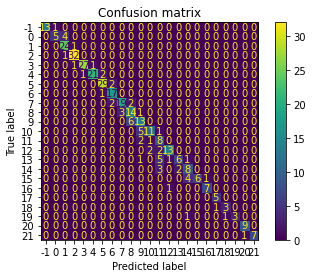

In [26]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.246737	valid_0's l2: 0.1379


In [28]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [29]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = median_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.14
RMSE: 0.37
MAE: 0.15


In [30]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [31]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.14
RMSE: 0.37

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.19
RMSE: 0.43

Round type: 0.45
MSE: 0.15
RMSE: 0.38



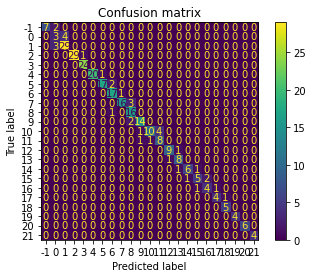

In [32]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [33]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 18:17:45,867] A new study created in memory with name: no-name-7ca2a14c-c2d9-46de-80dd-2fa8827658ca
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.169362 + 0.0476039
[200]	cv_agg's l2: 0.165173 + 0.0444588
[300]	cv_agg's l2: 0.164017 + 0.0439628
[400]	cv_agg's l2: 0.163727 + 0.0436844
[500]	cv_agg's l2: 0.163485 + 0.0434136


feature_fraction, val_score: 0.163407:  14%|######4                                      | 1/7 [00:04<00:28,  4.75s/it]

[600]	cv_agg's l2: 0.163532 + 0.0432932
Early stopping, best iteration is:
[516]	cv_agg's l2: 0.163407 + 0.0433308
[100]	cv_agg's l2: 0.165609 + 0.0415913
[200]	cv_agg's l2: 0.162609 + 0.0399952
[300]	cv_agg's l2: 0.161902 + 0.0383939
[400]	cv_agg's l2: 0.161161 + 0.0380871
[500]	cv_agg's l2: 0.161247 + 0.0379924


feature_fraction, val_score: 0.161045:  29%|############8                                | 2/7 [00:08<00:20,  4.06s/it]

Early stopping, best iteration is:
[440]	cv_agg's l2: 0.161045 + 0.0378613
[100]	cv_agg's l2: 0.175091 + 0.0450229
[200]	cv_agg's l2: 0.170872 + 0.0437134
[300]	cv_agg's l2: 0.169623 + 0.0430604
[400]	cv_agg's l2: 0.169216 + 0.0427181
[500]	cv_agg's l2: 0.169177 + 0.0425431


feature_fraction, val_score: 0.161045:  43%|###################2                         | 3/7 [00:11<00:15,  3.76s/it]

Early stopping, best iteration is:
[440]	cv_agg's l2: 0.161045 + 0.0378613
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.139095 + 0.0210417
[300]	cv_agg's l2: 0.136967 + 0.021258
[400]	cv_agg's l2: 0.136341 + 0.0210883
[500]	cv_agg's l2: 0.135944 + 0.0209275
[600]	cv_agg's l2: 0.135607 + 0.0207876
[700]	cv_agg's l2: 0.135481 + 0.0207375
[800]	cv_agg's l2: 0.135441 + 0.0206161
[900]	cv_agg's l2: 0.135403 + 0.0205771
[1000]	cv_agg's l2: 0.135369 + 0.0205016
[1100]	cv_agg's l2: 0.135308 + 0.0204345
[1200]	cv_agg's l2: 0.135297 + 0.0203813


feature_fraction, val_score: 0.135288:  57%|#########################7                   | 4/7 [00:20<00:17,  5.76s/it]

Early stopping, best iteration is:
[1183]	cv_agg's l2: 0.135288 + 0.0203932
[100]	cv_agg's l2: 0.163763 + 0.0512474
[200]	cv_agg's l2: 0.158424 + 0.0471932
[300]	cv_agg's l2: 0.157783 + 0.0464429
[400]	cv_agg's l2: 0.157636 + 0.0463709
[500]	cv_agg's l2: 0.157532 + 0.0460648
[600]	cv_agg's l2: 0.157482 + 0.0458167
[700]	cv_agg's l2: 0.157469 + 0.045867
[800]	cv_agg's l2: 0.15742 + 0.0457516
[900]	cv_agg's l2: 0.157376 + 0.0457067
[1000]	cv_agg's l2: 0.157386 + 0.0456908
[1100]	cv_agg's l2: 0.157376 + 0.045708
[1200]	cv_agg's l2: 0.15739 + 0.0457321


feature_fraction, val_score: 0.135288:  71%|################################1            | 5/7 [00:30<00:14,  7.20s/it]

Early stopping, best iteration is:
[1183]	cv_agg's l2: 0.135288 + 0.0203932
[100]	cv_agg's l2: 0.14374 + 0.0376429
[200]	cv_agg's l2: 0.139123 + 0.0341104
[300]	cv_agg's l2: 0.138095 + 0.0325451
[400]	cv_agg's l2: 0.137617 + 0.0316638
[500]	cv_agg's l2: 0.137236 + 0.0313274
[600]	cv_agg's l2: 0.137061 + 0.0311642
[700]	cv_agg's l2: 0.136842 + 0.0309636
[800]	cv_agg's l2: 0.136643 + 0.0307217
[900]	cv_agg's l2: 0.136556 + 0.0306288
[1000]	cv_agg's l2: 0.136514 + 0.0306438
[1100]	cv_agg's l2: 0.136431 + 0.0305984
[1200]	cv_agg's l2: 0.1364 + 0.0306145


feature_fraction, val_score: 0.135288:  86%|######################################5      | 6/7 [00:39<00:07,  7.73s/it]

Early stopping, best iteration is:
[1183]	cv_agg's l2: 0.135288 + 0.0203932
[100]	cv_agg's l2: 0.172926 + 0.0414372
[200]	cv_agg's l2: 0.168299 + 0.039411
[300]	cv_agg's l2: 0.167188 + 0.038648
[400]	cv_agg's l2: 0.16679 + 0.0383577
[500]	cv_agg's l2: 0.166594 + 0.0380808
[600]	cv_agg's l2: 0.166675 + 0.037919
[700]	cv_agg's l2: 0.166648 + 0.0378663
[800]	cv_agg's l2: 0.166603 + 0.0377953
[900]	cv_agg's l2: 0.166668 + 0.0377625
[1000]	cv_agg's l2: 0.166695 + 0.0377404
[1100]	cv_agg's l2: 0.166663 + 0.0376869
[1200]	cv_agg's l2: 0.166659 + 0.037638


feature_fraction, val_score: 0.135288: 100%|#############################################| 7/7 [00:50<00:00,  7.14s/it]


Early stopping, best iteration is:
[1183]	cv_agg's l2: 0.135288 + 0.0203932


num_leaves, val_score: 0.135288:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.134951:   5%|##5                                               | 1/20 [00:05<01:50,  5.82s/it]

Early stopping, best iteration is:
[736]	cv_agg's l2: 0.134951 + 0.0198879
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.134951:  10%|#####                                             | 2/20 [00:11<01:47,  6.00s/it]

Early stopping, best iteration is:
[736]	cv_agg's l2: 0.134951 + 0.0198879
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.134951:  15%|#######5                                          | 3/20 [00:18<01:46,  6.24s/it]

Early stopping, best iteration is:
[736]	cv_agg's l2: 0.134951 + 0.0198879
[100]	cv_agg's l2: 0.142941 + 0.0251199
[200]	cv_agg's l2: 0.137554 + 0.0240907
[300]	cv_agg's l2: 0.135621 + 0.0237979
[400]	cv_agg's l2: 0.134885 + 0.023746
[500]	cv_agg's l2: 0.134383 + 0.0234668
[600]	cv_agg's l2: 0.134106 + 0.0232292
[700]	cv_agg's l2: 0.13394 + 0.0231748
[800]	cv_agg's l2: 0.133823 + 0.0230816


num_leaves, val_score: 0.133768:  20%|##########                                        | 4/20 [00:25<01:44,  6.54s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.238223 + 0.043457
[200]	cv_agg's l2: 0.19977 + 0.0399049
[300]	cv_agg's l2: 0.183782 + 0.0388691
[400]	cv_agg's l2: 0.173854 + 0.0382215
[500]	cv_agg's l2: 0.168556 + 0.0379628
[600]	cv_agg's l2: 0.163596 + 0.0372758
[700]	cv_agg's l2: 0.159864 + 0.0358564


num_leaves, val_score: 0.133768:  20%|##########                                        | 4/20 [00:27<01:44,  6.54s/it]

[800]	cv_agg's l2: 0.157222 + 0.0353394
Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676


num_leaves, val_score: 0.133768:  25%|############5                                     | 5/20 [00:27<01:13,  4.87s/it]

[100]	cv_agg's l2: 0.143338 + 0.0206635
[200]	cv_agg's l2: 0.137691 + 0.0205884
[300]	cv_agg's l2: 0.136562 + 0.0206088
[400]	cv_agg's l2: 0.135675 + 0.0204818
[500]	cv_agg's l2: 0.135249 + 0.0203234
[600]	cv_agg's l2: 0.134958 + 0.0201833
[700]	cv_agg's l2: 0.13483 + 0.0200138
[800]	cv_agg's l2: 0.134808 + 0.0198785


num_leaves, val_score: 0.133768:  30%|###############                                   | 6/20 [00:32<01:11,  5.12s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.180838 + 0.0494502
[200]	cv_agg's l2: 0.160632 + 0.0445545
[300]	cv_agg's l2: 0.152535 + 0.0415822
[400]	cv_agg's l2: 0.149241 + 0.0403149
[500]	cv_agg's l2: 0.146448 + 0.0391086
[600]	cv_agg's l2: 0.144539 + 0.0378644
[700]	cv_agg's l2: 0.143496 + 0.037647
[800]	cv_agg's l2: 0.142539 + 0.0370637


num_leaves, val_score: 0.133768:  35%|#################5                                | 7/20 [00:35<00:56,  4.33s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  40%|####################                              | 8/20 [00:41<00:58,  4.89s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  45%|######################5                           | 9/20 [00:48<00:59,  5.37s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  50%|########################5                        | 10/20 [00:54<00:55,  5.56s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  55%|##########################9                      | 11/20 [01:00<00:52,  5.78s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  60%|#############################4                   | 12/20 [01:06<00:46,  5.85s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  65%|###############################8                 | 13/20 [01:12<00:41,  5.91s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  70%|##################################3              | 14/20 [01:18<00:35,  5.92s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  75%|####################################7            | 15/20 [01:24<00:29,  5.98s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  80%|#######################################2         | 16/20 [01:30<00:23,  5.96s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  85%|#########################################6       | 17/20 [01:36<00:17,  5.93s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  90%|############################################1    | 18/20 [01:42<00:11,  5.96s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.14302 + 0.0211128
[200]	cv_agg's l2: 0.138906 + 0.0207269
[300]	cv_agg's l2: 0.136774 + 0.0209404
[400]	cv_agg's l2: 0.135984 + 0.0205052
[500]	cv_agg's l2: 0.135559 + 0.0203001
[600]	cv_agg's l2: 0.135177 + 0.0200864
[700]	cv_agg's l2: 0.134997 + 0.0199495
[800]	cv_agg's l2: 0.135008 + 0.0199122


num_leaves, val_score: 0.133768:  95%|##############################################5  | 19/20 [01:48<00:06,  6.03s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.144514 + 0.0206499
[200]	cv_agg's l2: 0.138758 + 0.0192558
[300]	cv_agg's l2: 0.137332 + 0.0196444
[400]	cv_agg's l2: 0.136541 + 0.0194886
[500]	cv_agg's l2: 0.136162 + 0.0193045
[600]	cv_agg's l2: 0.135909 + 0.0190914
[700]	cv_agg's l2: 0.135845 + 0.0190173
[800]	cv_agg's l2: 0.135773 + 0.0189238


num_leaves, val_score: 0.133768: 100%|#################################################| 20/20 [01:54<00:00,  5.70s/it]


Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676


bagging, val_score: 0.133768:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.156685 + 0.0354863
[200]	cv_agg's l2: 0.148127 + 0.034377
[300]	cv_agg's l2: 0.146178 + 0.0343302
[400]	cv_agg's l2: 0.145066 + 0.0343262
[500]	cv_agg's l2: 0.144767 + 0.0341197
[600]	cv_agg's l2: 0.144656 + 0.0338011
[700]	cv_agg's l2: 0.144718 + 0.03379
[800]	cv_agg's l2: 0.144896 + 0.0337738


bagging, val_score: 0.133768:  10%|#####3                                               | 1/10 [00:05<00:47,  5.28s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.224933 + 0.0317668
[200]	cv_agg's l2: 0.205329 + 0.0219251
[300]	cv_agg's l2: 0.20084 + 0.0230789
[400]	cv_agg's l2: 0.196445 + 0.018284
[500]	cv_agg's l2: 0.193633 + 0.0164146
[600]	cv_agg's l2: 0.193858 + 0.015555
[700]	cv_agg's l2: 0.190716 + 0.0157373
[800]	cv_agg's l2: 0.191116 + 0.0180283


bagging, val_score: 0.133768:  20%|##########6                                          | 2/10 [00:08<00:32,  4.04s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.143111 + 0.0228027
[200]	cv_agg's l2: 0.137067 + 0.0233207
[300]	cv_agg's l2: 0.135132 + 0.0234495
[400]	cv_agg's l2: 0.134617 + 0.0232696
[500]	cv_agg's l2: 0.134523 + 0.0233433
[600]	cv_agg's l2: 0.134447 + 0.0232909
[700]	cv_agg's l2: 0.134468 + 0.023148
[800]	cv_agg's l2: 0.134624 + 0.023065


bagging, val_score: 0.133768:  30%|###############9                                     | 3/10 [00:13<00:32,  4.67s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.141712 + 0.0225605
[200]	cv_agg's l2: 0.135221 + 0.0218255
[300]	cv_agg's l2: 0.134123 + 0.0216172
[400]	cv_agg's l2: 0.13426 + 0.0209347
[500]	cv_agg's l2: 0.13444 + 0.0205357
[600]	cv_agg's l2: 0.134467 + 0.0203107
[700]	cv_agg's l2: 0.13451 + 0.02028
[800]	cv_agg's l2: 0.134584 + 0.0200973


bagging, val_score: 0.133768:  40%|#####################2                               | 4/10 [00:19<00:29,  4.95s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.143166 + 0.0222382
[200]	cv_agg's l2: 0.137209 + 0.0224501
[300]	cv_agg's l2: 0.135702 + 0.0214412
[400]	cv_agg's l2: 0.135505 + 0.0212214
[500]	cv_agg's l2: 0.134967 + 0.0212655
[600]	cv_agg's l2: 0.134903 + 0.0210482
[700]	cv_agg's l2: 0.134856 + 0.0208762
[800]	cv_agg's l2: 0.134757 + 0.020746


bagging, val_score: 0.133768:  50%|##########################5                          | 5/10 [00:24<00:25,  5.14s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.142656 + 0.0226736
[200]	cv_agg's l2: 0.137542 + 0.0234747
[300]	cv_agg's l2: 0.135186 + 0.0228104
[400]	cv_agg's l2: 0.134667 + 0.0226417
[500]	cv_agg's l2: 0.134455 + 0.0227066
[600]	cv_agg's l2: 0.134302 + 0.0226371
[700]	cv_agg's l2: 0.134308 + 0.0225272
[800]	cv_agg's l2: 0.134288 + 0.0224753


bagging, val_score: 0.133768:  60%|###############################8                     | 6/10 [00:31<00:22,  5.67s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.141974 + 0.0218763
[200]	cv_agg's l2: 0.135736 + 0.020607
[300]	cv_agg's l2: 0.135209 + 0.0207145
[400]	cv_agg's l2: 0.134712 + 0.0203207
[500]	cv_agg's l2: 0.1344 + 0.0205093
[600]	cv_agg's l2: 0.134341 + 0.0203398
[700]	cv_agg's l2: 0.134202 + 0.0203055
[800]	cv_agg's l2: 0.134063 + 0.0201983


bagging, val_score: 0.133768:  70%|#####################################                | 7/10 [00:36<00:16,  5.56s/it]

Early stopping, best iteration is:
[768]	cv_agg's l2: 0.133768 + 0.0230676
[100]	cv_agg's l2: 0.142602 + 0.01922
[200]	cv_agg's l2: 0.136328 + 0.0191245
[300]	cv_agg's l2: 0.134869 + 0.0185873
[400]	cv_agg's l2: 0.134355 + 0.0184299
[500]	cv_agg's l2: 0.133799 + 0.017836
[600]	cv_agg's l2: 0.133675 + 0.0175661


bagging, val_score: 0.133658:  80%|##########################################4          | 8/10 [00:40<00:10,  5.08s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.146153 + 0.0299074
[200]	cv_agg's l2: 0.140068 + 0.0291011
[300]	cv_agg's l2: 0.137356 + 0.0273545
[400]	cv_agg's l2: 0.136512 + 0.0271953
[500]	cv_agg's l2: 0.136232 + 0.0265952
[600]	cv_agg's l2: 0.136146 + 0.0262698


bagging, val_score: 0.133658:  90%|###############################################7     | 9/10 [00:45<00:04,  4.90s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142941 + 0.0251199
[200]	cv_agg's l2: 0.137554 + 0.0240907
[300]	cv_agg's l2: 0.135621 + 0.0237979
[400]	cv_agg's l2: 0.134885 + 0.023746
[500]	cv_agg's l2: 0.134383 + 0.0234668
[600]	cv_agg's l2: 0.134106 + 0.0232292


bagging, val_score: 0.133658: 100%|####################################################| 10/10 [00:50<00:00,  5.08s/it]


Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062


feature_fraction_stage2, val_score: 0.133658:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.15443 + 0.0266637
[200]	cv_agg's l2: 0.148753 + 0.026019
[300]	cv_agg's l2: 0.146769 + 0.0247258
[400]	cv_agg's l2: 0.146159 + 0.0240349
[500]	cv_agg's l2: 0.145824 + 0.0241745
[600]	cv_agg's l2: 0.145564 + 0.0241618


feature_fraction_stage2, val_score: 0.133658:  33%|############6                         | 1/3 [00:04<00:08,  4.04s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.153527 + 0.0263124
[200]	cv_agg's l2: 0.148242 + 0.0254282
[300]	cv_agg's l2: 0.146762 + 0.0239503
[400]	cv_agg's l2: 0.146205 + 0.0234052
[500]	cv_agg's l2: 0.14591 + 0.0228811
[600]	cv_agg's l2: 0.145797 + 0.0224235


feature_fraction_stage2, val_score: 0.133658:  67%|#########################3            | 2/3 [00:08<00:04,  4.26s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.145059 + 0.0263702
[200]	cv_agg's l2: 0.139803 + 0.0263403
[300]	cv_agg's l2: 0.138267 + 0.0260814
[400]	cv_agg's l2: 0.137797 + 0.0258767
[500]	cv_agg's l2: 0.13747 + 0.0255959
[600]	cv_agg's l2: 0.13723 + 0.0254194


feature_fraction_stage2, val_score: 0.133658: 100%|######################################| 3/3 [00:12<00:00,  4.30s/it]


Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062


regularization_factors, val_score: 0.133658:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145757 + 0.0301804
[200]	cv_agg's l2: 0.138508 + 0.0306163
[300]	cv_agg's l2: 0.136879 + 0.0308689
[400]	cv_agg's l2: 0.136853 + 0.0308772
[500]	cv_agg's l2: 0.136853 + 0.0308772
[600]	cv_agg's l2: 0.136853 + 0.0308772


regularization_factors, val_score: 0.133658:   5%|#9                                    | 1/20 [00:02<00:43,  2.27s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  10%|###8                                  | 2/20 [00:06<01:02,  3.48s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  15%|#####7                                | 3/20 [00:10<01:04,  3.78s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  20%|#######6                              | 4/20 [00:15<01:04,  4.01s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  25%|#########5                            | 5/20 [00:19<01:02,  4.17s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  30%|###########4                          | 6/20 [00:23<00:59,  4.22s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  35%|#############3                        | 7/20 [00:28<00:54,  4.20s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  40%|###############2                      | 8/20 [00:32<00:52,  4.41s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133658:  45%|#################1                    | 9/20 [00:37<00:49,  4.50s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133701 + 0.0177171


regularization_factors, val_score: 0.133658:  50%|##################5                  | 10/20 [00:42<00:45,  4.53s/it]

Early stopping, best iteration is:
[584]	cv_agg's l2: 0.133658 + 0.0176062
[100]	cv_agg's l2: 0.142698 + 0.0194874
[200]	cv_agg's l2: 0.136409 + 0.0199625
[300]	cv_agg's l2: 0.134571 + 0.0193229
[400]	cv_agg's l2: 0.134085 + 0.0191632
[500]	cv_agg's l2: 0.133515 + 0.0192318
[600]	cv_agg's l2: 0.133346 + 0.0189663


regularization_factors, val_score: 0.133255:  55%|####################3                | 11/20 [00:46<00:39,  4.41s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133701 + 0.0177171


regularization_factors, val_score: 0.133255:  60%|######################2              | 12/20 [00:50<00:34,  4.31s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142698 + 0.0194874
[200]	cv_agg's l2: 0.136635 + 0.0197351
[300]	cv_agg's l2: 0.135168 + 0.0186937
[400]	cv_agg's l2: 0.134586 + 0.0184171
[500]	cv_agg's l2: 0.134232 + 0.0180592
[600]	cv_agg's l2: 0.134094 + 0.0178594


regularization_factors, val_score: 0.133255:  65%|########################             | 13/20 [00:54<00:29,  4.24s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134868 + 0.0185629
[400]	cv_agg's l2: 0.134268 + 0.0183042
[500]	cv_agg's l2: 0.134091 + 0.0181065
[600]	cv_agg's l2: 0.133874 + 0.0178034


regularization_factors, val_score: 0.133255:  70%|#########################9           | 14/20 [00:58<00:25,  4.23s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133726 + 0.0176512


regularization_factors, val_score: 0.133255:  75%|###########################7         | 15/20 [01:02<00:20,  4.18s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142572 + 0.0194627
[200]	cv_agg's l2: 0.136747 + 0.0200871
[300]	cv_agg's l2: 0.134927 + 0.0196257
[400]	cv_agg's l2: 0.134325 + 0.019586
[500]	cv_agg's l2: 0.133769 + 0.0196746
[600]	cv_agg's l2: 0.133554 + 0.0193993


regularization_factors, val_score: 0.133255:  80%|#############################6       | 16/20 [01:06<00:16,  4.14s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142242 + 0.0186023
[200]	cv_agg's l2: 0.136582 + 0.0197357
[300]	cv_agg's l2: 0.135653 + 0.0196692
[400]	cv_agg's l2: 0.13481 + 0.0191655
[500]	cv_agg's l2: 0.134416 + 0.0189888
[600]	cv_agg's l2: 0.134095 + 0.0188255


regularization_factors, val_score: 0.133255:  85%|###############################4     | 17/20 [01:11<00:13,  4.34s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142572 + 0.0194627
[200]	cv_agg's l2: 0.136747 + 0.0200871
[300]	cv_agg's l2: 0.135186 + 0.0193499
[400]	cv_agg's l2: 0.134664 + 0.019228
[500]	cv_agg's l2: 0.1341 + 0.0193303
[600]	cv_agg's l2: 0.133823 + 0.0191195


regularization_factors, val_score: 0.133255:  90%|#################################3   | 18/20 [01:16<00:08,  4.44s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142758 + 0.0195003
[200]	cv_agg's l2: 0.136686 + 0.0197522
[300]	cv_agg's l2: 0.134851 + 0.0185566
[400]	cv_agg's l2: 0.134286 + 0.0183116
[500]	cv_agg's l2: 0.133909 + 0.0180215
[600]	cv_agg's l2: 0.133754 + 0.0176646


regularization_factors, val_score: 0.133255:  95%|###################################1 | 19/20 [01:20<00:04,  4.49s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.142698 + 0.0194874
[200]	cv_agg's l2: 0.136409 + 0.0199625
[300]	cv_agg's l2: 0.134571 + 0.0193229
[400]	cv_agg's l2: 0.134085 + 0.0191632
[500]	cv_agg's l2: 0.133689 + 0.0193228
[600]	cv_agg's l2: 0.13358 + 0.0190933


regularization_factors, val_score: 0.133255: 100%|#####################################| 20/20 [01:25<00:00,  4.26s/it]


Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369


min_data_in_leaf, val_score: 0.133255:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.219025 + 0.03612
[200]	cv_agg's l2: 0.207306 + 0.0324879
[300]	cv_agg's l2: 0.204274 + 0.0309149
[400]	cv_agg's l2: 0.202972 + 0.0310518
[500]	cv_agg's l2: 0.203645 + 0.0303679
[600]	cv_agg's l2: 0.203542 + 0.0302336


min_data_in_leaf, val_score: 0.133255:  20%|#########                                    | 1/5 [00:02<00:10,  2.68s/it]

Early stopping, best iteration is:
[563]	cv_agg's l2: 0.133255 + 0.0189369
[100]	cv_agg's l2: 0.139367 + 0.0233575
[200]	cv_agg's l2: 0.134648 + 0.023768
[300]	cv_agg's l2: 0.133341 + 0.0236243
[400]	cv_agg's l2: 0.13281 + 0.023498
[500]	cv_agg's l2: 0.132702 + 0.0232964


min_data_in_leaf, val_score: 0.132677:  40%|##################                           | 2/5 [00:06<00:09,  3.19s/it]

Early stopping, best iteration is:
[488]	cv_agg's l2: 0.132677 + 0.0233252
[100]	cv_agg's l2: 0.145403 + 0.029566
[200]	cv_agg's l2: 0.141659 + 0.0301457
[300]	cv_agg's l2: 0.140856 + 0.0302325
[400]	cv_agg's l2: 0.140517 + 0.0301365
[500]	cv_agg's l2: 0.140473 + 0.03026


min_data_in_leaf, val_score: 0.132677:  60%|###########################                  | 3/5 [00:09<00:06,  3.38s/it]

Early stopping, best iteration is:
[488]	cv_agg's l2: 0.132677 + 0.0233252
[100]	cv_agg's l2: 0.690671 + 0.0582682
[200]	cv_agg's l2: 0.64666 + 0.0459884
[300]	cv_agg's l2: 0.620474 + 0.0459598
[400]	cv_agg's l2: 0.609529 + 0.0498212
[500]	cv_agg's l2: 0.598048 + 0.048383


min_data_in_leaf, val_score: 0.132677:  80%|####################################         | 4/5 [00:11<00:02,  2.71s/it]

Early stopping, best iteration is:
[488]	cv_agg's l2: 0.132677 + 0.0233252
[100]	cv_agg's l2: 0.148663 + 0.0262138
[200]	cv_agg's l2: 0.142969 + 0.0240728
[300]	cv_agg's l2: 0.142229 + 0.0238407
[400]	cv_agg's l2: 0.142363 + 0.0235619
[500]	cv_agg's l2: 0.14221 + 0.023166


min_data_in_leaf, val_score: 0.132677: 100%|#############################################| 5/5 [00:15<00:00,  3.01s/it]

Early stopping, best iteration is:
[488]	cv_agg's l2: 0.132677 + 0.0233252


In [34]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1326772927876827
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 8.772188748737766e-06
    lambda_l2: 2.1117822542936693e-06
    num_leaves: 21
    feature_fraction: 0.4
    bagging_fraction: 0.9909029780815463
    bagging_freq: 1
    min_child_samples: 10


In [35]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [36]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.31
MSE test: 0.10
MAE test: 0.22



In [37]:
results.loc[4] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

In [38]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.03
RMSE: 0.18

Round type: round
MSE: 0.04
RMSE: 0.20

Round type: 0.33
MSE: 0.04
RMSE: 0.20

Round type: 0.45
MSE: 0.03
RMSE: 0.18



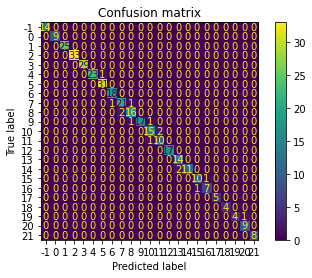

In [39]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [40]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,50,0.927292,0.962960,0.235042
1,chronological,Optuna,50,0.434040,0.658817,0.371587
3,random,normal,50,0.137900,0.371349,0.152952
4,random,Optuna,50,0.098534,0.313902,0.222457


In [41]:
from training.results import plot_summary

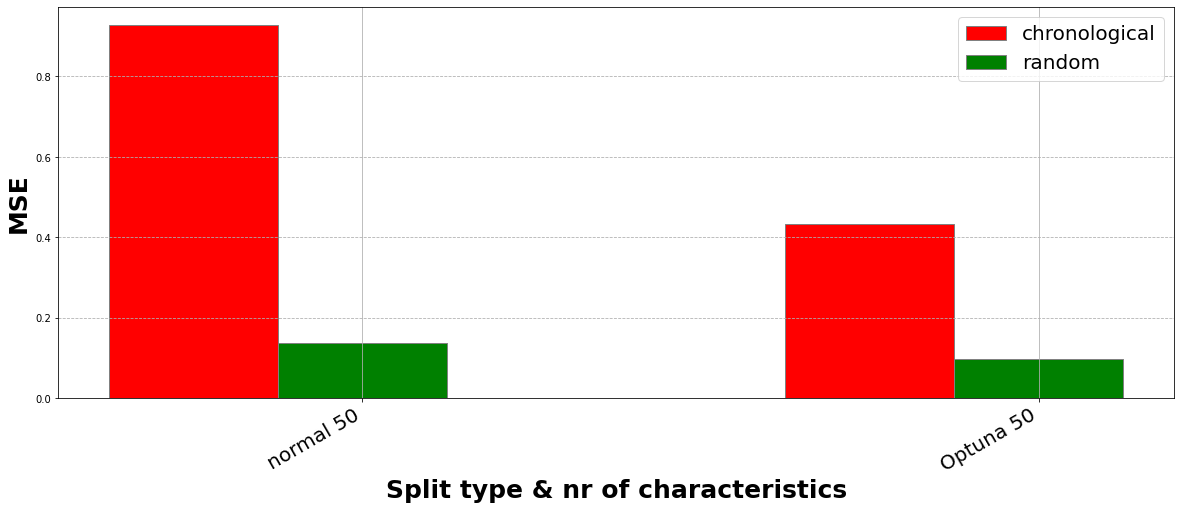

In [42]:
plot_summary(results, "MSE")

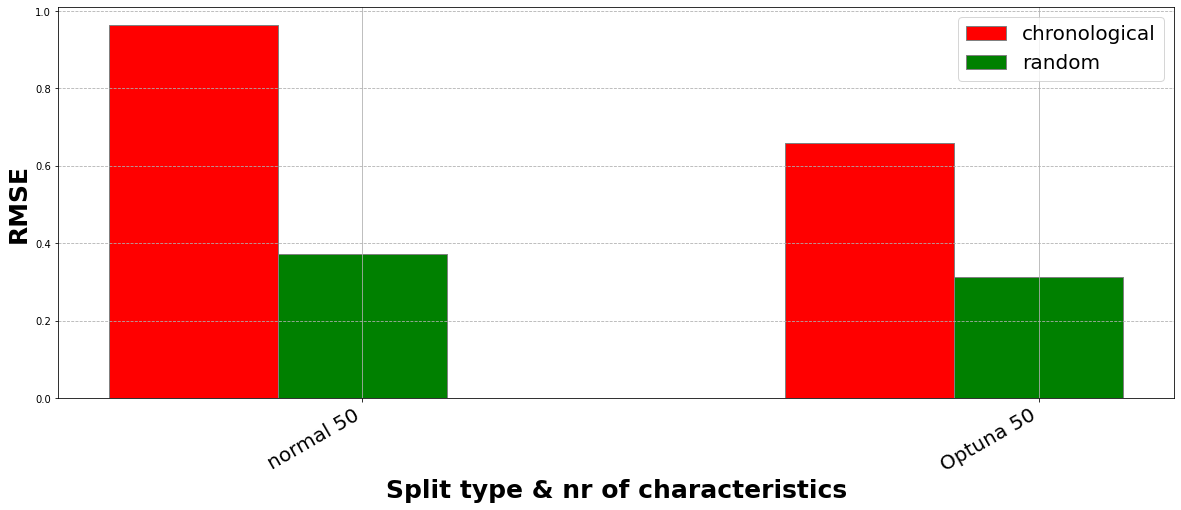

In [43]:
plot_summary(results, "RMSE")

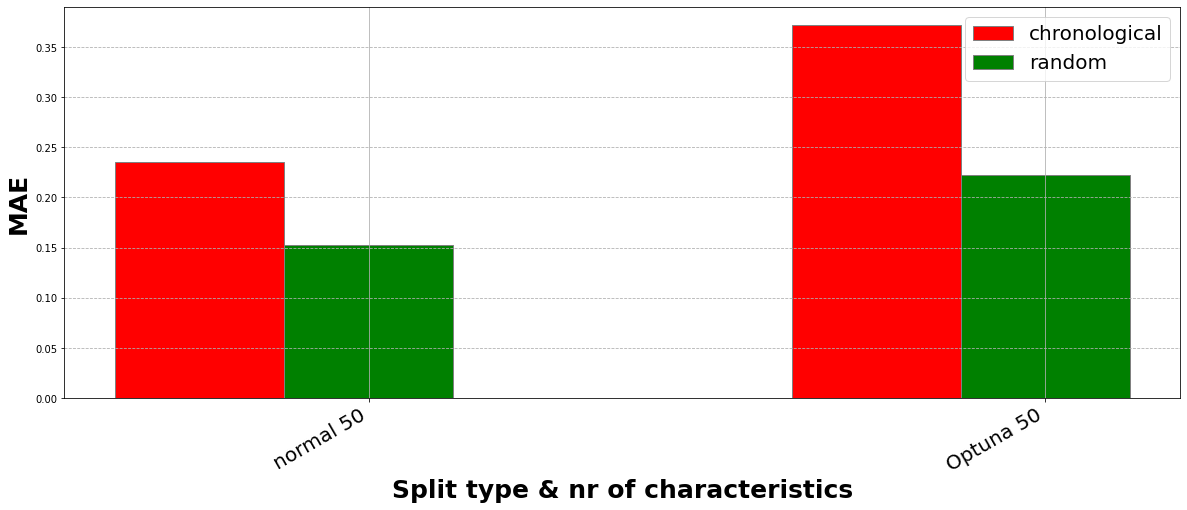

In [44]:
plot_summary(results, "MAE")

In [47]:
results.to_json("./lightgbm_final_results.json")